## data generation

In [1]:
from locally_connected import LocallyConnected
from lbfgsb_scipy import LBFGSBScipy
from trace_expm import trace_expm
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import numpy as np
import scipy.sparse
import GraphNOTEARS
import notears_torch_version
import lasso
import dynotears
import utils as ut
import matplotlib.pyplot as plt
import networkx as nx
import dgl
import random
import utils as ut
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import pandas as pd
#device = torch.device("cuda:0")
device = torch.device("cuda")

D:\Anaconda\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using backend: pytorch


In [2]:
def data_pre(n, d, s0, w_graph_type, p_graph_type, sem_type,ratio):
    #binary W
    w_true = ut.simulate_dag(d, s0, w_graph_type)
    #weighted W
    w_mat = ut.simulate_parameter(w_true)
    w_test_mat=w_mat.copy()
    #A
    adj1 = ut.generate_adj(n) 
    #node to target
    num_target=np.nonzero(w_mat[:,-1])[0]#4,14
    n_suprious=-1.0
    suprious_dict={}
    #if no suprious variable existed
    if len(num_target)==0:
        return w_mat,w_mat, w_mat, w_mat,w_mat,w_mat,n_suprious
    else:
        #create the spurious variable
        for i in range(len(num_target)):
            suprious_list=np.nonzero(w_mat[num_target[i],:])[0]#12

            for j in range(len(suprious_list)): 
                suprious=suprious_list[j]
                #count the number of suprious variable
                if suprious not in suprious_dict:
                    suprious_dict[suprious]=1
                    n_suprious+=1
                    #remove other outgoing link
                    w_mat[suprious,:]=0 #12,0
                    w_test_mat[suprious,:]=0
                    #print(suprious)
                    #revert the link in the test
                    if suprious!=d-1:
                        w_test_mat[num_target[i],suprious]=ratio*w_test_mat[num_target[i],suprious]
                
                
    num_step = 5 #cannot work if num_step=1
    #initial X0=X0W+B
    Xbase = []
    Xbase1 = ut.simulate_linear_sem(w_mat, n, sem_type, noise_scale=0.5)
    #X1=X1W+AX0W+B
    for i in range(num_step):
        Xbase1 = ut.simulate_linear_sem_with_P(w_mat, w_mat, adj1@Xbase1, n, sem_type, noise_scale=1)
        Xbase.append(Xbase1)
        
    #test data
    Xbase_test = []
    Xbase1_test = ut.simulate_linear_sem(w_test_mat, n, sem_type, noise_scale=0.5)
    for i in range(num_step):
        Xbase1_test = ut.simulate_linear_sem_with_P(w_test_mat, w_test_mat, adj1@Xbase1_test, n, sem_type, noise_scale=1)
        Xbase_test.append(Xbase1_test)
    
    return Xbase,Xbase_test, adj1, w_true,w_mat,w_test_mat,n_suprious

In [10]:
torch.set_default_dtype(torch.double)
np.set_printoptions(precision=3)

torch.manual_seed(12345)
ut.set_random_seed(12345)

n = 50 #number of people

d = 5 #number of features

w_graph_type = 'ER'
p_graph_type = 'ER' 
sem_type = 'exp'
s0 =  d
output=pd.DataFrame(columns=["train_acc","valid_acc","test_acc","model","n_suprious"])
ith=0
replicates=100

In [13]:
Xlags,Xlags_test, adj1, w_true,w_mat,w_test_mat,n_suprious = data_pre(n, d, s0, w_graph_type,p_graph_type, sem_type,-0.3)

In [14]:
n_suprious

2.0

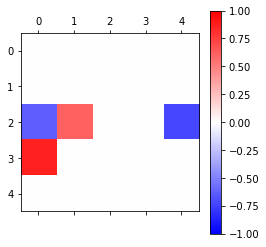

In [15]:
##True W
import matplotlib.pyplot as plt
plt.matshow(w_mat,cmap = 'bwr', vmin = -1, vmax = 1)
plt.colorbar()
plt.show()

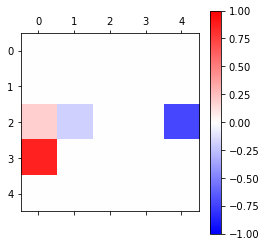

In [16]:
##True W
import matplotlib.pyplot as plt
plt.matshow(w_test_mat,cmap = 'bwr', vmin = -1, vmax = 1)
plt.colorbar()
plt.show()

In [99]:
Xlags[-1][:,-1].mean()

0.2204410486384874

In [95]:
Xlags[-1].mean(axis=0)

array([0.202, 0.981, 1.061, 0.768, 0.22 ])

In [91]:
Xlags[-1][:].mean(axis=0)[-1]

0.2204410486384874

In [3]:
def get_node_feature(Xlags,node_num):
#     for num_lags in range(1):
#         if num_lags==0:
#             X_feature=Xlags[num_lags][node_num]
#         else:
#             X_feature=np.append(X_feature,Xlags[num_lags][node_num])##shape num_lags*5 (250)
    X_feature=Xlags[-1][node_num]
    return(X_feature)
def to_binary(x):
    if x>Xlags[-1][:,-1].mean():
        return 1
    else:
        return 0

In [4]:
def create_graph(valid_list,adj1,Xlags,n):
 ##node list for validation
    labels=[]
    G = nx.from_numpy_array(adj1)
    for node_num in range(n):
        G.nodes[node_num]['feature']=get_node_feature(Xlags,node_num)[:-1]

        G.nodes[node_num]['label']=to_binary(get_node_feature(Xlags,node_num)[-1])

        labels.append(G.nodes[node_num]['label'])
        if node_num in valid_list:
            G.nodes[node_num]['train_mask']=False
            G.nodes[node_num]['valid_mask']=True
        else:
            G.nodes[node_num]['train_mask']=True
            G.nodes[node_num]['valid_mask']=False
    g = dgl.from_networkx(G, node_attrs=['feature','label','train_mask','valid_mask'])
    return g

## GCN

In [5]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(14, 8)
        self.layer2 = GCNLayer(8, 2)

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x


In [7]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [8]:
class atten_Net(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats,n_node):
        super(atten_Net, self).__init__()
        self.layer1 = GCNLayer(in_feats, hid_feats)
        self.layer2 = GCNLayer(hid_feats, out_feats)
        self.att_mlp_1 = nn.Linear(n_node, hid_feats)
        self.att_mlp_2 = nn.Linear(hid_feats, 2)
        self.layer3 = GCNLayer(in_feats*2, hid_feats)
        self.layer4 = GCNLayer(hid_feats, out_feats)

    def forward(self, g, features,dag):
        ##use mlp to get attention weights
        node_att = F.relu(self.att_mlp_1(dag))
        node_att = F.softmax(self.att_mlp_2(node_att), dim=-1)
        node_weight_c = node_att[:, 0]
        node_weight_o = node_att[:, 1]
        ##attention on the causal/trival part
        feature_c = node_weight_c.view(1, -1) * features
        feature_o = node_weight_o.view(1, -1) * features
        ## apply the mask on the features
        xc = F.relu(self.layer1(g, feature_c))
        xc = self.layer2(g, xc)
        xc=F.log_softmax(xc, dim=-1)
        
        xo = F.relu(self.layer1(g, feature_o))
        xo = self.layer2(g, xo)
        xo=F.log_softmax(xo, dim=-1)
        ##xco        
        num = xc.shape[0]
        l = [i for i in range(num)]
        random.shuffle(l)
        random_idx = torch.tensor(l)
        xco = torch.cat((feature_c[random_idx], feature_o), dim=1)
        xco = F.relu(self.layer3(g, xco))
        xco = self.layer4(g, xco)
        xco=F.log_softmax(xco, dim=-1)
        
        return xc,xo,xco

In [9]:
def evaluate_new(model, g, features, labels, mask,dag):
    model.eval()
    with torch.no_grad():
        logits_c,logits_o,logits_co = model(g, features,dag)
        logits = logits_o[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [10]:
torch.set_default_dtype(torch.double)
np.set_printoptions(precision=3)

torch.manual_seed(12345)
ut.set_random_seed(12345)

n = 50 #number of people

d = 15 #number of features

w_graph_type = 'ER'
p_graph_type = 'ER' 
sem_type = 'exp'
s0 =  d
#params
ratio=-0.3
lr=0.01
alpha=0.2
beta=1
gamma=0.2
early_stop_thresh=50
n_epoch=300
output=pd.DataFrame(columns=["train_acc","valid_acc","test_acc","model","n_suprious"])
ith=0
replicates=50
while ith<2*replicates:
    print("-------------------the",ith//2,"iteration------------------")
    #create data
    Xlags,Xlags_test, adj1, w_true,w_mat,w_test_mat,n_suprious = data_pre(n, d, s0, w_graph_type,p_graph_type, sem_type,ratio)
    if n_suprious<=0:
        continue
    Xlags_torch = torch.Tensor(np.array(Xlags))
    print("finish data!")
    #fit the causal graph
    adj1_torch = torch.Tensor(adj1)
    model_1 = GraphNOTEARS.model_p1_MLP(dims=[d, n, 1], bias=True)
    W_est_1, P1_est_1 = GraphNOTEARS.linear_model(model_1, Xlags_torch, adj1_torch,  lambda1 = 0.01, lambda2 = 0.01, lambda3 = 0.01)
    print("finish fit graph!")
    #g,g_test
    valid_list=random.sample(range(n), int(n*0.4))
    g = create_graph(valid_list,adj1,Xlags,n)
    g_test=create_graph(valid_list,adj1,Xlags_test,n)
    #GCN
    gcn_msg = fn.copy_u(u="h", out="m")
    gcn_reduce = fn.sum(msg="m", out="h")

    net = Net()

    features = g.ndata['feature']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    valid_mask = g.ndata['valid_mask']
    ###test
    features_test = g_test.ndata['feature']
    labels_test = g_test.ndata['label']
    #parameters
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    best_loss = 99998
    best_epoch = -1
    for epoch in range(n_epoch):
        net.train()
        logits = net(g, features)
        logp = F.log_softmax(logits, dim=-1)
        loss = F.nll_loss(logp[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ##evaluate
        net.eval()
        train_acc = evaluate(net, g, features, labels, train_mask)
        valid_acc = evaluate(net, g, features, labels, valid_mask)
        test_acc = evaluate(net, g_test, features_test, labels_test, valid_mask)
        valid_loss = F.nll_loss(logp[valid_mask], labels[valid_mask])
        #early stop
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
            #torch.save(net.state_dict(), "GCN_demo_large.pth")
        elif epoch - best_epoch > early_stop_thresh:
            print("Early stopped training at epoch %d" % epoch)
            break  # terminate the training loop
    print("GCN:train",train_acc,"valid",valid_acc,"test",test_acc)
    output.loc[ith]=[train_acc,valid_acc,test_acc,"GCN",n_suprious]
    ith+=1
    ##proposed
    model = atten_Net(in_feats=d-1, hid_feats=8, out_feats=2,n_node=d)

    #params
    best_loss = 99998
    best_epoch = -1

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    for epoch in range(n_epoch):
        model.train()
        xc_logits,xo_logits,xco_logits = model(g, features,torch.tensor(W_est_1[:-1,:]))
        ##trivial part
        uniform_target = torch.ones_like(xc_logits[train_mask], dtype=torch.float)/2
        c_loss = F.kl_div(xc_logits[train_mask], uniform_target, reduction='batchmean')

        o_loss = F.nll_loss(xo_logits[train_mask], labels[train_mask])
        co_loss= F.nll_loss(xco_logits[train_mask], labels[train_mask])
        loss = alpha * c_loss + beta * o_loss +gamma*co_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        ##evaluate
        model.eval()
        train_acc = evaluate_new(model, g, features, labels, train_mask,torch.tensor(W_est_1[:-1,:]))
        valid_acc = evaluate_new(model, g, features, labels, valid_mask,torch.tensor(W_est_1[:-1,:]))
        test_acc = evaluate_new(model, g_test, features_test, labels_test, valid_mask,torch.tensor(W_est_1[:-1,:]))
        #valid loss
        uniform_target = torch.ones_like(xc_logits[valid_mask], dtype=torch.float)/2
        valid_c_loss = F.kl_div(xc_logits[valid_mask], uniform_target, reduction='batchmean')
        valid_o_loss = F.nll_loss(xo_logits[valid_mask], labels[valid_mask])
        valid_co_loss = F.nll_loss(xco_logits[valid_mask], labels[valid_mask])
        valid_loss = alpha * valid_c_loss+beta *valid_o_loss+gamma*valid_co_loss
        #test loss
        test_xc_logits,test_xo_logits,test_xco_logits = model(g_test, features_test,torch.tensor(W_est_1[:-1,:]))
        uniform_target = torch.ones_like(test_xo_logits[valid_mask], dtype=torch.float)/2
        test_c_loss = F.kl_div(test_xc_logits[valid_mask], uniform_target, reduction='batchmean')
        test_o_loss = F.nll_loss(test_xo_logits[valid_mask], labels_test[valid_mask])
        test_co_loss = F.nll_loss(test_xco_logits[valid_mask], labels_test[valid_mask])
        test_loss = alpha * test_c_loss + beta * test_o_loss+gamma*test_co_loss
    #early stop     
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
            #torch.save(model.state_dict(), "attention_demo_large.pth")
        elif epoch - best_epoch > early_stop_thresh:
            print("Early stopped training at epoch %d" % epoch)
            break  # terminate the training loop
    print("proposed:train",train_acc,"valid",valid_acc,"test",test_acc,"n_suprious",n_suprious)
    output.loc[ith]=[train_acc,valid_acc,test_acc,"proposed",n_suprious]
    ith+=1
    if ith %20==0:
        print(output.groupby("model").mean())

-------------------the 0 iteration------------------
finish data!
finish fit graph!


D:\Anaconda\lib\site-packages\dgl\backend\pytorch\tensor.py:40: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)



Early stopped training at epoch 97
GCN:train 0.7 valid 0.55 test 0.7
Early stopped training at epoch 107
proposed:train 0.7333333333333333 valid 0.6 test 0.6 n_suprious 2.0
-------------------the 1 iteration------------------
finish data!
finish fit graph!
Early stopped training at epoch 226
GCN:train 0.9 valid 0.65 test 0.55
Early stopped training at epoch 251
proposed:train 0.7666666666666667 valid 0.5 test 0.45 n_suprious 1.0
-------------------the 2 iteration------------------
finish data!
finish fit graph!
Early stopped training at epoch 92
GCN:train 0.7 valid 0.55 test 0.75
Early stopped training at epoch 88
proposed:train 0.7333333333333333 valid 0.55 test 0.45 n_suprious 2.0
-------------------the 3 iteration------------------
-------------------the 3 iteration------------------
-------------------the 3 iteration------------------
finish data!
finish fit graph!
Early stopped training at epoch 82
GCN:train 0.8 valid 0.8 test 0.4
Early stopped training at epoch 203
proposed:train

Early stopped training at epoch 105
GCN:train 0.4666666666666667 valid 0.5 test 0.4
Early stopped training at epoch 120
proposed:train 0.5666666666666667 valid 0.6 test 0.3 n_suprious 1.0
-------------------the 26 iteration------------------
finish data!
finish fit graph!
Early stopped training at epoch 94
GCN:train 0.7 valid 0.6 test 0.25
Early stopped training at epoch 144
proposed:train 0.7666666666666667 valid 0.55 test 0.75 n_suprious 1.0
-------------------the 27 iteration------------------
finish data!
finish fit graph!
Early stopped training at epoch 233
GCN:train 0.5666666666666667 valid 0.6 test 0.65
Early stopped training at epoch 136
proposed:train 0.6666666666666666 valid 0.6 test 0.65 n_suprious 1.0
-------------------the 28 iteration------------------
-------------------the 28 iteration------------------
finish data!
finish fit graph!
Early stopped training at epoch 97
GCN:train 0.8333333333333334 valid 0.7 test 0.4
proposed:train 0.6333333333333333 valid 0.75 test 0.6 n

finish fit graph!
Early stopped training at epoch 119
GCN:train 0.8666666666666667 valid 0.6 test 0.55
Early stopped training at epoch 132
proposed:train 0.7666666666666667 valid 0.55 test 0.55 n_suprious 2.0
          train_acc  valid_acc  test_acc  n_suprious
model                                               
GCN        0.744000      0.560     0.531        2.14
proposed   0.701333      0.536     0.560        2.14


In [11]:
output.to_csv("ratio=-0.3,d=15,lr=0.01,alpha=0.2,beta=1,gamma=0.2,early_stop_thresh=50,n_epoch=300.csv")

In [12]:
output.groupby("model").mean()

,train_acc,valid_acc,test_acc,n_suprious
model,,,,
GCN,0.744000,0.560,0.531,2.14
proposed,0.701333,0.536,0.560,2.14


In [15]:
output.groupby("model").std()/np.sqrt(50)

,train_acc,valid_acc,test_acc,n_suprious
model,,,,
GCN,0.017128,0.017023,0.019634,0.166623
proposed,0.014722,0.016723,0.017555,0.166623


In [15]:
diff_list=[]
for i in range(50):
    GCN=output.loc[i*2]["test_acc"]
    proposed=output.loc[i*2+1]["test_acc"]
    diff=proposed-GCN
    diff_list.append(diff)
    

In [17]:
0.133539/np.sqrt(50)

0.018885266490574072

In [22]:
np.mean(diff_list)

0.020999999999999998

In [77]:
Xlags,Xlags_test, adj1, w_true,w_mat,w_test_mat,n_suprious = data_pre(n, d, s0, w_graph_type,p_graph_type, sem_type)
if n_suprious<=0:
    print("not valid")
Xlags_torch = torch.Tensor(np.array(Xlags))
print("finish data!")
#fit the causal graph
adj1_torch = torch.Tensor(adj1)
model_1 = GraphNOTEARS.model_p1_MLP(dims=[d, n, 1], bias=True)
W_est_1, P1_est_1 = GraphNOTEARS.linear_model(model_1, Xlags_torch, adj1_torch,  lambda1 = 0.01, lambda2 = 0.01, lambda3 = 0.01)
print("finish fit graph!")
#g,g_test
valid_list=random.sample(range(n), int(n*0.4))
g = create_graph(valid_list,adj1,Xlags,n)
g_test=create_graph(valid_list,adj1,Xlags_test,n)


finish data!
finish fit graph!


In [78]:
lr=0.01
alpha=0.2
beta=1
gamma=0.2
early_stop_thresh=300
n_epoch=50

In [79]:
    gcn_msg = fn.copy_u(u="h", out="m")
    gcn_reduce = fn.sum(msg="m", out="h")

    net = Net()

    features = g.ndata['feature']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    valid_mask = g.ndata['valid_mask']
    ###test
    features_test = g_test.ndata['feature']
    labels_test = g_test.ndata['label']
    ###metric
    train_acc_list=[]
    valid_acc_list=[]
    test_acc_list=[]
    loss_list=[]
    #parameters
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    best_loss = 99998
    best_epoch = -1
    for epoch in range(n_epoch):
        net.train()
        logits = net(g, features)
        logp = F.log_softmax(logits, dim=-1)
        loss = F.nll_loss(logp[train_mask], labels[train_mask])
        loss_list.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ##evaluate
        net.eval()
        train_acc = evaluate(net, g, features, labels, train_mask)
        valid_acc = evaluate(net, g, features, labels, valid_mask)
        test_acc = evaluate(net, g_test, features_test, labels_test, valid_mask)
        valid_loss = F.nll_loss(logp[valid_mask], labels[valid_mask])
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        test_acc_list.append(test_acc)
        #early stop
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
            #torch.save(net.state_dict(), "GCN_demo_large.pth")
        elif epoch - best_epoch > early_stop_thresh:
            print("Early stopped training at epoch %d" % epoch)
            break  # terminate the training loop
    print("GCN:train",train_acc,"valid",valid_acc,"test",test_acc)

GCN:train 0.6 valid 0.45 test 0.5


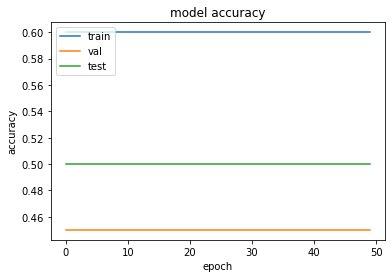

In [80]:
from matplotlib import pyplot as plt
#history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(train_acc_list)
plt.plot(valid_acc_list)
plt.plot(test_acc_list)
#plt.plot(loss_list)
#plt.plot(loss_list)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val','test','loss'], loc='upper left')
plt.show()

In [81]:
##proposed
model = atten_Net(in_feats=d-1, hid_feats=3, out_feats=2,n_node=d)

#params
best_loss = 99998
best_epoch = -1
###metric
train_acc_list=[]
valid_acc_list=[]
test_acc_list=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
for epoch in range(n_epoch):
    model.train()
    xc_logits,xo_logits,xco_logits = model(g, features,torch.tensor(W_est_1[:-1,:]))
    ##trivial part
    uniform_target = torch.ones_like(xc_logits[train_mask], dtype=torch.float)/2
    c_loss = F.kl_div(xc_logits[train_mask], uniform_target, reduction='batchmean')

    o_loss = F.nll_loss(xo_logits[train_mask], labels[train_mask])
    co_loss= F.nll_loss(xco_logits[train_mask], labels[train_mask])
    loss = alpha * c_loss + beta * o_loss +gamma*co_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()
    ##evaluate
    model.eval()
    train_acc = evaluate_new(model, g, features, labels, train_mask,torch.tensor(W_est_1[:-1,:]))
    valid_acc = evaluate_new(model, g, features, labels, valid_mask,torch.tensor(W_est_1[:-1,:]))
    test_acc = evaluate_new(model, g_test, features_test, labels_test, valid_mask,torch.tensor(W_est_1[:-1,:]))
    #valid loss
    uniform_target = torch.ones_like(xc_logits[valid_mask], dtype=torch.float)/2
    valid_c_loss = F.kl_div(xc_logits[valid_mask], uniform_target, reduction='batchmean')
    valid_o_loss = F.nll_loss(xo_logits[valid_mask], labels[valid_mask])
    valid_co_loss = F.nll_loss(xco_logits[valid_mask], labels[valid_mask])
    valid_loss = alpha * valid_c_loss+beta *valid_o_loss+gamma*valid_co_loss
    #test loss
    test_xc_logits,test_xo_logits,test_xco_logits = model(g_test, features_test,torch.tensor(W_est_1[:-1,:]))
    uniform_target = torch.ones_like(test_xc_logits[valid_mask], dtype=torch.float)/2
    test_c_loss = F.kl_div(test_xc_logits[valid_mask], uniform_target, reduction='batchmean')
    test_o_loss = F.nll_loss(test_xo_logits[valid_mask], labels_test[valid_mask])
    test_co_loss = F.nll_loss(test_xco_logits[valid_mask], labels_test[valid_mask])
    test_loss = alpha * test_c_loss + beta * test_o_loss+gamma*test_co_loss
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)
    test_acc_list.append(test_acc)
#early stop     
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_epoch = epoch
        #torch.save(model.state_dict(), "attention_demo_large.pth")
    elif epoch - best_epoch > early_stop_thresh:
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop
print("proposed:train",train_acc,"valid",valid_acc,"test",test_acc,"n_suprious",n_suprious)

proposed:train 0.6 valid 0.45 test 0.55 n_suprious 2.0


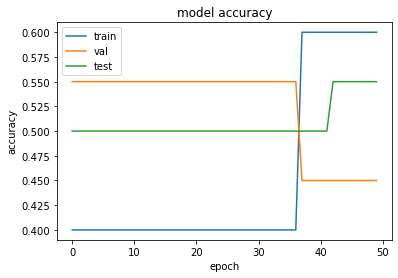

In [82]:
from matplotlib import pyplot as plt
#history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(train_acc_list)
plt.plot(valid_acc_list)
plt.plot(test_acc_list)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val','test'], loc='upper left')
plt.show()

In [249]:
str(n)+str(d)

'505'

In [19]:
output_new=output

In [22]:
output_new.groupby("model").mean()

,train_acc,valid_acc,test_acc,n_suprious
model,,,,
GCN,0.872000,0.844,0.738,1.44
proposed,0.863333,0.848,0.711,1.44


In [1]:
a=output

NameError: name 'output' is not defined

In [96]:
a.groupby("model").mean()

,train_acc,valid_acc,test_acc,n_suprious
model,,,,
GCN,0.869667,0.837,0.704,1.43
proposed,0.868000,0.835,0.696,1.43


In [97]:
a.groupby("model").std()

,train_acc,valid_acc,test_acc,n_suprious
model,,,,
GCN,0.137893,0.171391,0.300814,0.49757
proposed,0.142127,0.172108,0.306716,0.49757


In [93]:
i

49

In [94]:
diff_list=[]
for i in range(50):
    GCN=a.loc[i*2]["test_acc"]
    proposed=a.loc[i*2+1]["test_acc"]
    diff=proposed-GCN
    diff_list.append(diff)
    

In [88]:
np.mean(diff_list)

0.005999999999999992

In [89]:
np.std(diff_list)

0.3775764823184834

In [72]:
a.groupby("model").mean()

,train_acc,valid_acc,test_acc,n_suprious
model,,,,
GCN,0.832000,0.798,0.618,1.36
proposed,0.825333,0.810,0.660,1.36


In [67]:
output.to_csv("n_feature=5.csv")

In [40]:
output.groupby("model").mean()

,train_acc,valid_acc,test_acc,n_suprious
model,,,,
GCN,0.837500,0.67500,0.64375,1.625
proposed,0.820833,0.70625,0.71250,1.625


In [41]:
output

,train_acc,valid_acc,test_acc,model,n_suprious
0,0.966667,0.80,0.85,GCN,3.0
1,0.966667,0.85,0.75,proposed,3.0
2,0.800000,0.45,0.50,GCN,0.0
3,0.633333,0.50,0.55,proposed,0.0
4,0.733333,0.40,0.50,GCN,1.0
5,0.766667,0.55,0.60,proposed,1.0
6,0.700000,0.60,0.65,GCN,0.0
7,0.733333,0.60,0.70,proposed,0.0
8,1.000000,0.80,0.25,GCN,6.0
9,1.000000,0.80,0.70,proposed,6.0
